## 5. This notebook explores topic modeling using LDA algorithm. 

A.  Highlights
1. Applied pre-processing steps to text corpus. (We intentionally did not remove stopwords)
2. Used gensim library to tokenize unigram corpus.
3. Applied gensim phrases and phraser to train a bigram corpus 
4. Used spacy to lemmatize bigram corpus
5. Built a dictionary of lematized words and a corpus of bag of words. 
6. LDA fitted model resulted in -9.91 model perplexity and topic coherence score of 0.38
7. Use pyLDAvis to plot an interactive web-visual. 
8. Used Word Cloud to visualize difficult text and topics.


In [1]:
# Import libraries: 
import gensim
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
import spacy
import pandas as pd
import re
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
tqdm.pandas()

In [2]:
# Get normed text from extracted features: 
df_train = pd.read_csv('extracted_train_features_with_stopwords_pca.csv') 
df_test = pd.read_csv('extracted_test_features_with_stopwords_pca.csv')

In [3]:
df_train.head(2)

,original_text,norm_text,nlp_norm_text,lemma,pos,label,english,pca1,pca2,pca3,...,CCONJ,ADJ,NUM,X,INTJ,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,There is manuscript evidence that Austen conti...,there is manuscript evidence that austen conti...,there is manuscript evidence that austen conti...,"['there', 'be', 'manuscript', 'evidence', 'tha...","['PRON', 'AUX', 'NOUN', 'NOUN', 'SCONJ', 'PROP...",1,1,-1.241217,0.088320,-0.179642,...,3.0,1.0,0.0,0.0,0.0,0.0,58,35,6,4.485714
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,in a remarkable comparative analysis mandaean ...,"['in', 'a', 'remarkable', 'comparative', 'anal...","['ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'PROPN', ...",1,1,-0.709833,0.029789,-0.094246,...,0.0,3.0,0.0,0.0,0.0,0.0,45,22,8,5.818182


In [4]:
def build_corpus(df, text):
    """convert normalized text in to a list of origina text: corpus"""
    return [x for x in df[text]]


In [5]:
# This is the list of pre-processed sentences:
corpus = build_corpus(df_train,'norm_text')  
corpus[:5]

['there is manuscript evidence that austen continued to work on these pieces as late as the period â and that her niece and nephew anna and james edward austen made further additions as late as',
 'in a remarkable comparative analysis mandaean scholar säve söderberg demonstrated that mani s psalms of thomas were closely related to mandaean texts',
 'before persephone was released to hermes who had been sent to retrieve her hades tricked her into eating pomegranate seeds lrb six or three according to the telling rrb which forced her to return to the underworld for a period each year',
 'cogeneration plants are commonly found in district heating systems of cities hospitals prisons oil refineries paper mills wastewater treatment plants thermal enhanced oil recovery wells and industrial plants with large heating needs',
 'geneva lrb rrb is the second most populous city in switzerland lrb after zürich rrb and is the most populous city of romandie lrb the french speaking part of switzerland 

In [6]:
# Now, convert sentences in the corpus to words: 
def sentence_to_words(corpus):
    """Pass corpus to convert sentences to words"""
    for sentence in corpus:
        yield gensim.utils.simple_preprocess(sentence, deacc=True)   # remove accent marks (This was missed in extracted Features)

In [7]:
tokenizer = sentence_to_words(corpus)

# Get the tokenized corpus
corpus_tok = [word for word in tokenizer]

In [8]:
print(corpus_tok[:5])

[['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'and', 'that', 'her', 'niece', 'and', 'nephew', 'anna', 'and', 'james', 'edward', 'austen', 'made', 'further', 'additions', 'as', 'late', 'as'], ['in', 'remarkable', 'comparative', 'analysis', 'mandaean', 'scholar', 'save', 'soderberg', 'demonstrated', 'that', 'mani', 'psalms', 'of', 'thomas', 'were', 'closely', 'related', 'to', 'mandaean', 'texts'], ['before', 'persephone', 'was', 'released', 'to', 'hermes', 'who', 'had', 'been', 'sent', 'to', 'retrieve', 'her', 'hades', 'tricked', 'her', 'into', 'eating', 'pomegranate', 'seeds', 'lrb', 'six', 'or', 'three', 'according', 'to', 'the', 'telling', 'rrb', 'which', 'forced', 'her', 'to', 'return', 'to', 'the', 'underworld', 'for', 'period', 'each', 'year'], ['cogeneration', 'plants', 'are', 'commonly', 'found', 'in', 'district', 'heating', 'systems', 'of', 'cities', 'hospitals', 'prisons', 'o

In [10]:
# Train a bigram model 
from gensim.models.phrases import Phrases, Phraser

def build_bigram(unigram_tokens):

    # Pass unigram tokens to Phrases 
    unigram = Phrases(unigram_tokens)

    # Pass unigram Phrases to Phraser to get bigram: 
    bigram = Phraser(unigram)
    
    return [bigram[word] for word in unigram_tokens]

In [11]:
bigram_corpus = build_bigram(corpus_tok)

In [12]:
print(bigram_corpus[0])

['there', 'is', 'manuscript', 'evidence', 'that', 'austen', 'continued', 'to', 'work', 'on', 'these', 'pieces', 'as', 'late', 'as', 'the', 'period', 'and', 'that', 'her', 'niece', 'and', 'nephew', 'anna', 'and', 'james', 'edward', 'austen', 'made', 'further', 'additions', 'as', 'late', 'as']


In [13]:
# Lemmatize bigram_corpus:
from tqdm import tqdm
tqdm.pandas()
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
def get_lemma_or_pos(text, option=None):
    """Pass option as lemma or pos string to obtain lemma or pos from bigram corpus"""
    lemma = []
    pos = []

    for words in tqdm(text): 
        nlp_text = nlp(" ".join(words))
        lemma.append([token.lemma_ for token in nlp_text])
        pos.append([token.pos_ for token in nlp_text])
        
    if option=='lemma':
        return lemma
    if option== 'pos':          
        return pos

In [14]:
# data lemma (run time- 14 minutes)
data_lemma = get_lemma_or_pos(bigram_corpus, option = 'lemma')
# data pos(optional- run time 14 minutes)
data_pos = get_lemma_or_pos(bigram_corpus, option = 'pos')

100%|██████████| 416239/416239 [17:35<00:00, 394.27it/s]


In [15]:
print(data_lemma[:1], data_pos[:1])

[['there', 'be', 'manuscript', 'evidence', 'that', 'austen', 'continue', 'to', 'work', 'on', 'these', 'piece', 'as', 'late', 'as', 'the', 'period', 'and', 'that', '-PRON-', 'niece', 'and', 'nephew', 'anna', 'and', 'james', 'edward', 'austen', 'make', 'further', 'addition', 'as', 'late', 'as']] [['PRON', 'AUX', 'NOUN', 'NOUN', 'SCONJ', 'PROPN', 'VERB', 'PART', 'VERB', 'ADP', 'DET', 'NOUN', 'ADV', 'ADV', 'SCONJ', 'DET', 'NOUN', 'CCONJ', 'SCONJ', 'DET', 'NOUN', 'CCONJ', 'PROPN', 'PROPN', 'CCONJ', 'PROPN', 'PROPN', 'PROPN', 'VERB', 'ADJ', 'NOUN', 'ADV', 'ADV', 'SCONJ']]


In [16]:
# We can use data_pos get a count of pos tags and compare it with our previous feature set which contains unigrams

In [17]:
# Create a dictionary: 
id2word = corpora.Dictionary(data_lemma)

In [18]:
type(id2word)

gensim.corpora.dictionary.Dictionary

In [19]:
# Create Corpus from the dictionary: 
corpus_bow = [id2word.doc2bow(word) for word in data_lemma if word!= 'None']

In [20]:
print(corpus_bow[:1])

[[(0, 1), (1, 1), (2, 3), (3, 1), (4, 4), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1)]]


In [21]:
# Get words from the dictionary: 
print([id2word.get(i) for i in range(20)])

['-PRON-', 'addition', 'and', 'anna', 'as', 'austen', 'be', 'continue', 'edward', 'evidence', 'further', 'james', 'late', 'make', 'manuscript', 'nephew', 'niece', 'on', 'period', 'piece']


### Build Topic Model using LDA: 
#### LdaModel
- **num_topics** : this is the number of topics you need to define beforehand
- **chunksize** : the number of documents to be used in each training chunk
- **alpha** : this is the hyperparameters that affect the sparsity of the topics
- **passess** : total number of training pssess

In [22]:
%%time
# LDA model: 
#  We chose num_topics same as best_K obtained from K-means to help interpret clusters
lda_model = LdaModel(corpus=corpus_bow,
                     num_topics=12,      #Same as best_K obtained from K-means implementation  
                     id2word=id2word,
                     random_state=0,
                     alpha='auto', 
                     update_every=1,
                     chunksize =2000, 
                     passes=10,
                     per_word_topics=True)

CPU times: user 13min 58s, sys: 8.1 s, total: 14min 6s
Wall time: 14min 26s


In [30]:
# Print key words in top 12 topics: 
from pprint import pprint
pprint(lda_model.print_topics(12))

[(0,
  '0.088*"-PRON-" + 0.076*"and" + 0.049*"to" + 0.021*"for" + 0.020*"on" + '
  '0.019*"by" + 0.016*"have" + 0.016*"as" + 0.015*"that" + 0.015*"from"'),
 (1,
  '0.099*"find" + 0.090*"france" + 0.054*"commune" + 0.029*"pas_de" + '
  '0.015*"calais" + 0.014*"calais_department" + 0.014*"region_nord" + '
  '0.013*"aisne_department" + 0.013*"region_picardie" + '
  '0.012*"calvados_department"'),
 (2,
  '0.096*"team" + 0.085*"football_player" + 0.045*"former" + 0.024*"japanese" '
  '+ 0.021*"currently" + 0.021*"hit" + 0.021*"computer" + 0.020*"special" + '
  '0.017*"japanese_football" + 0.015*"network"'),
 (3,
  '0.045*"september" + 0.042*"bear" + 0.042*"die" + 0.039*"august" + '
  '0.038*"july" + 0.038*"october" + 0.037*"june" + 0.036*"november" + '
  '0.035*"december" + 0.029*"march"'),
 (4,
  '0.048*"university" + 0.034*"type" + 0.029*"study" + 0.022*"list" + '
  '0.017*"college" + 0.016*"unit" + 0.014*"lot" + 0.013*"class" + '
  '0.011*"process" + 0.010*"science"'),
 (5,
  '0.112*"lrb

In [24]:
doc_lda = lda_model[corpus_bow]

In [25]:
# View model output
print([doc_lda[word] for word in range(1)])

[([(0, 0.65751916), (2, 0.023915596), (9, 0.10970494), (10, 0.1556099), (11, 0.0122195855)], [(0, [0]), (1, [0]), (2, [0, 10]), (3, [9]), (4, [0]), (5, [9]), (6, [10, 0]), (7, [0]), (8, [2]), (9, [0]), (10, [0]), (11, [0, 5]), (12, [0]), (13, [0]), (14, [0]), (15, [9]), (16, [9]), (17, [0]), (18, [0, 10]), (19, [0]), (20, [0]), (21, [10]), (22, [0]), (23, [0]), (24, [0]), (25, [0])], [(0, [(0, 0.99999803)]), (1, [(0, 0.99922776)]), (2, [(0, 2.9496927), (10, 0.050300393)]), (3, [(9, 0.9994278)]), (4, [(0, 3.9999552)]), (5, [(9, 1.9987428)]), (6, [(0, 0.13124716), (10, 0.8687482)]), (7, [(0, 0.99978405)]), (8, [(2, 0.9992782)]), (9, [(0, 0.9984356)]), (10, [(0, 0.9991964)]), (11, [(0, 0.9872904), (5, 0.012229466)]), (12, [(0, 1.9994262)]), (13, [(0, 0.9999755)]), (14, [(0, 0.995447)]), (15, [(9, 0.9984785)]), (16, [(9, 0.99738693)]), (17, [(0, 0.99986583)]), (18, [(0, 0.85650486), (10, 0.14317082)]), (19, [(0, 0.9996534)]), (20, [(0, 1.9999754)]), (21, [(10, 0.999775)]), (22, [(0, 0.9999

### Evaluate Topic Models: 
1. Model Perplexity: Predicts how well a probability model predicts the sample (Lower score is better)
2. Model Coherence: It measures the degree of semantic similarity between high scoring words in a topic.

In [26]:
%%time
# Model Perplexity: 
print("Perplexity: ", lda_model.log_perplexity(corpus_bow))

Perplexity:  -9.910687889869209
CPU times: user 1min 16s, sys: 770 ms, total: 1min 17s
Wall time: 1min 18s


In [27]:
%%time
# Model Coherence:
coherence_model_lda = CoherenceModel(model = lda_model,
                                     texts = data_lemma,
                                     dictionary = id2word,
                                     coherence= 'c_v')

coherence_lda = coherence_model_lda.get_coherence()

print('Coherence Score: ', coherence_lda)

Coherence Score:  0.3801492140722729
CPU times: user 5.31 s, sys: 651 ms, total: 5.96 s
Wall time: 22.3 s


### Visualize Topic Model:
1. Use pyLDAvis to help users interpret topics LDA model has fitted to the corpus of text data
2. Use pyLDAvis to extract information from a fitted LDA model in an interactive web-based visualization

In [28]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
%%time
# Visualizatize topics: 
vis = pyLDAvis.gensim.prepare(topic_model=lda_model,
                              corpus=corpus_bow,
                              dictionary=id2word)

vis

CPU times: user 3min 38s, sys: 3.07 s, total: 3min 41s
Wall time: 3min 56s


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.350961 -0.176130       1        1  41.623875
10    -0.353084  0.047041       2        1  38.176010
11    -0.049415  0.387917       3        1   4.552023
1     -0.005684  0.081815       4        1   2.873225
5      0.047944 -0.114178       5        1   2.371868
3      0.056831 -0.103290       6        1   2.261241
4      0.081650 -0.012094       7        1   1.922607
9      0.082227 -0.011567       8        1   1.811161
7      0.110221 -0.019980       9        1   1.333423
8      0.123319 -0.025740      10        1   1.166252
6      0.129669 -0.027151      11        1   0.968620
2      0.127284 -0.026643      12        1   0.939696, topic_info=                Term           Freq          Total Category  logprob  loglift
21               the  692524.000000  692524.000000  Default  30.0000  30.0000
58               rrb  122090.000000  122090.000000  Default  29.0000  29.0000
6                 be  415699.000000  415699.000000  Default  28.0000  28.0000
33                of  342943.000000  342943.000000  Default  27.0000  27.0000
51               lrb  102772.000000  102772.000000  Default  26.0000  26.0000
...              ...            ...            ...      ...      ...      ...
5782           fifth     503.439301     504.684631  Topic12  -4.8465   4.6649
16240  former_german     497.193451     498.438751  Topic12  -4.8589   4.6649
2712       liverpool     491.065094     492.310425  Topic12  -4.8713   4.6648
8945            tall     448.351532     449.596832  Topic12  -4.9623   4.6646
1731           heavy     433.644073     434.889404  Topic12  -4.9957   4.6645

[413 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
0          1  0.999994         -PRON-
599        1  0.999871          about
4409       3  0.997877  about_million
504        5  0.999421          actor
4855       5  0.999294        actress
...      ...       ...            ...
5641       4  0.998906       would_be
11310      3  0.998057      wrestling
468        5  0.999209         writer
208        8  0.998641     written_by
5126       3  0.998913            wwe

[396 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 12, 2, 6, 4, 5, 10, 8, 9, 7, 3])

### Observation: 
1. Topics 5 to 12 seems to overlap quite a bit. This could be due to the presence of stopwords or basic English words we extracted from additional features. But, there could also be words such as 'lrb', 'rrb', 'km' which have occured throughout the text frequently and are difficult to comprehend.  
2. Hence, if we filter out stopwords, basic English words would we see difficult text? Let's explore this. 

In [73]:
# Extract words from lda_model:
my_dict = {'Topic_' + str(i): [token for token, score in lda_model.show_topic(i, topn=100)] for i in range(0, lda_model.num_topics)}

In [74]:
# Build topic model dataframe: 
topic_model = pd.DataFrame(my_dict, columns = list(my_dict.keys()))

In [75]:
topic_model.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9,Topic_10,Topic_11
0,-PRON-,find,team,september,university,lrb_born,language,national,water,like,the,rrb
1,and,france,football_player,bear,type,player,ii,de_la,official,plant,be,lrb
2,to,commune,former,die,study,an_american,award,law,common,color,of,km
3,for,pas_de,japanese,august,list,he_plays,publish,central,genus,short,in,also_known
4,on,calais,currently,july,college,actor,world_war,party,organization,article,city,wwe


In [76]:
# Get stopwords and basic english words from additional features we extracted earlier.
from nltk.corpus import stopwords
import numpy as np

# Stopwords:
stopword = list(stopwords.words('english'))

# Additional features:
additional_features = pd.read_csv('additional_features.csv')

In [170]:
def remove_noise_from_topics(df, col):
    
    """This function will return words from the topic which are neither a single stopword nor included in additional features"""
    
    return df[col][(~df[col].isin(stopword+['-PRON-'])) & (~df[col].isin(list(additional_features['Word'])))]

In [199]:
# View topics after removing some of the easy text:
topics = pd.DataFrame([np.unique(topic_words(topic_model,i)) for i in topic_model.columns]).T.fillna(0)
topics.columns = ["topic_"+str(i) for i in range(1, len(topic_model.columns)+1)]                                          
display(topics.iloc[0:20,:])

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12
0,can_be,aisne_department,algeria,about_kilometre,adams,academy_award,alt,almost_all,commonly,afghanistan,american,about_million
1,has_been,alabama,andrew,an_average,ain_department,albert,at_least,an_important,derived_from,associated_with,australia,adam
2,such_as,alpes_te,argentina_national,an_inclination,al,an_american,billy,austrian,en,brazilian,british,also_known
3,there_are,arda_che,avon,ancient_greek,atlantic,an_english,chemical_compound,charles,frequently,completely,california,arabic
4,0,armenia,brazil_national,april,australian,an_italian,currently_play,common_year,game_boy,directed_by,canton,census_bureau
5,0,aube_da,brazilian_football,bach,british_rail,april,detroit,de_la,game_console,has_become,de,comic_strip
6,0,away_from,brian,brazil,cm,arkansas,disney_channel,divided_into,google,her_mother,england,czech
7,0,azur,cable_television,ca,connecticut,armenian,dolj_county,finland,hans,karl,english,daniel
8,0,belgian_province,country_music,catherine,david,basketball_player,dumbledore,great_britain,hungary,may_be,europe,denmark
9,0,bouches_du,currently_playe,des,et,best_known,east_timor,gregorian_calendar,isbn,nasa,french,dvd


In [204]:
# Plot filtered topic in Word Cloud:  
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS

def word_cloud(df, col=None):
    
    """This function converts difficult text in each topic and converts it in to a word cloud object"""
    cloud_text = " ".join(map(str, df[col].tolist()))
    return WordCloud(max_font_size=50,
                     max_words=100, 
                     background_color="white",
                     stopwords=STOPWORDS).generate(cloud_text)

topic_1:


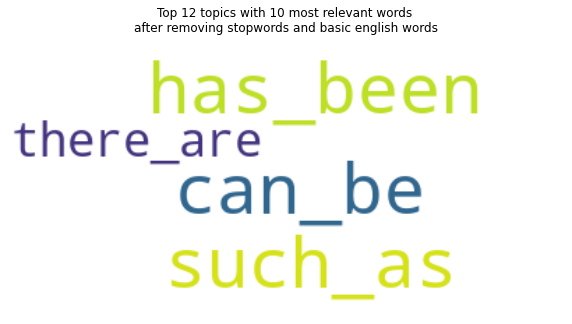

topic_2:


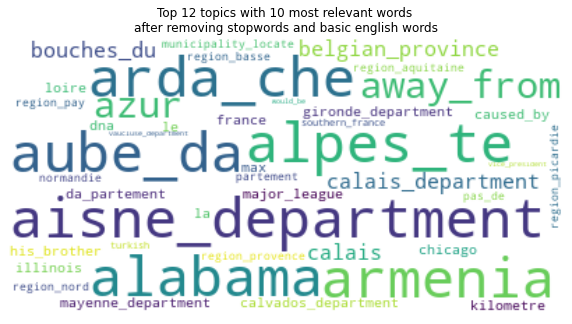

topic_3:


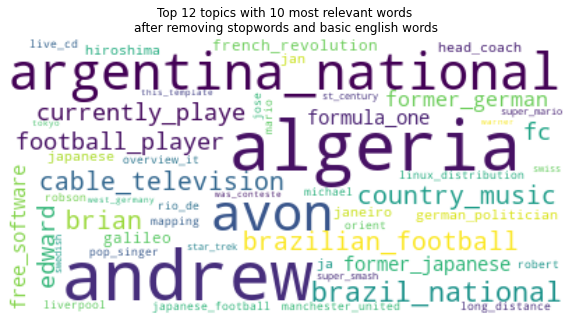

topic_4:


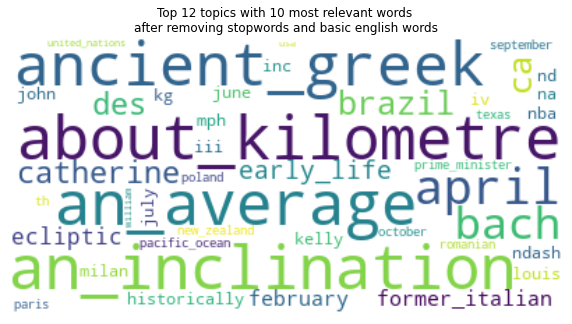

topic_5:


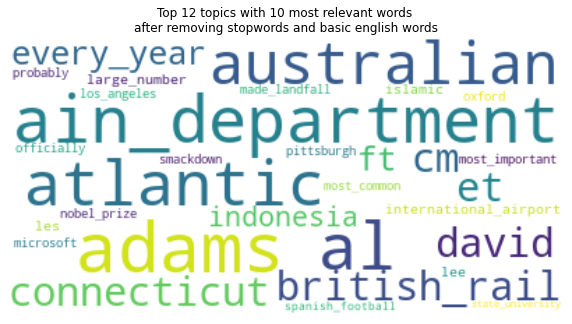

topic_6:


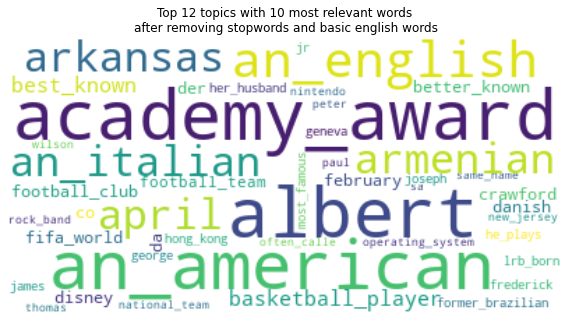

topic_7:


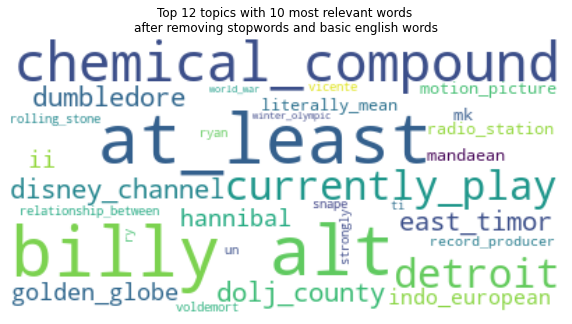

topic_8:


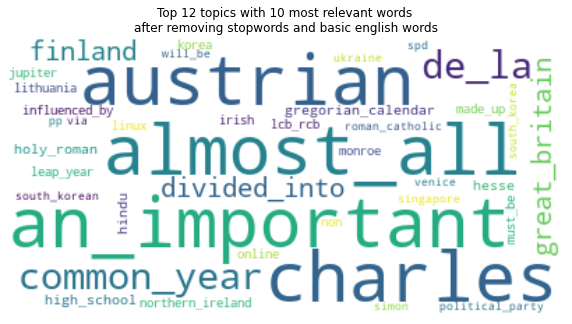

topic_9:


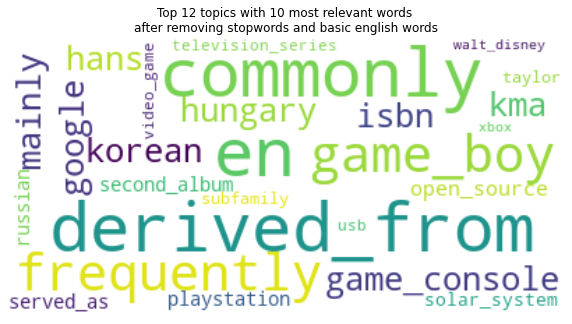

topic_10:


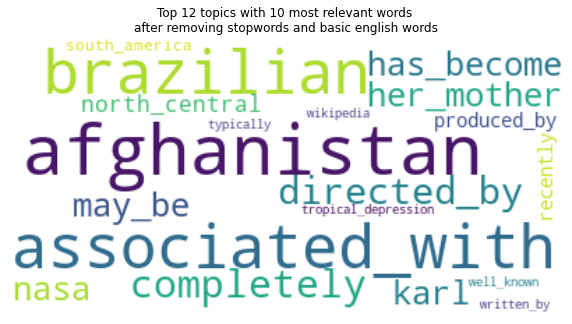

topic_11:


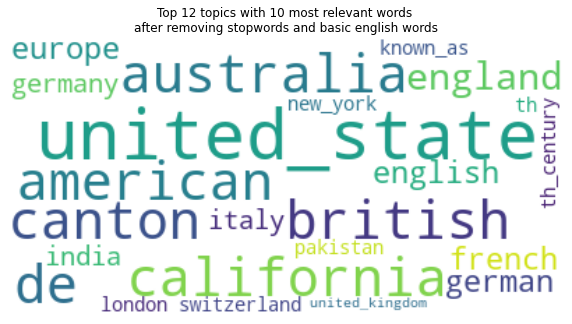

topic_12:


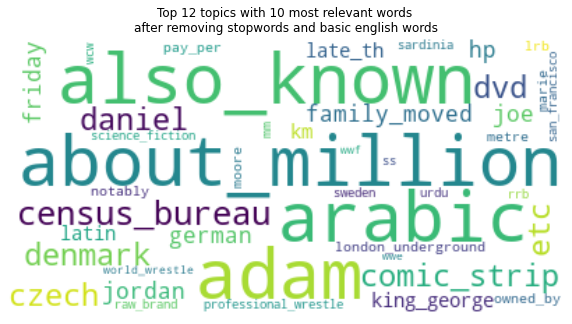

In [205]:
# Plot WordCloud object using matplot lib
for i in topics.columns: 
    _ = plt.figure(figsize = (10,10))
    _ =print(i+':'),plt.imshow(word_cloud(topics, i), interpolation="bilinear")
    _ =plt.axis("off")
    _ = plt.title('Top 12 topics with 10 most relevant words \nafter removing stopwords and basic english words')
    _ = plt.show()

###### Observation: 
1. Through wordcloud visual, after filtering out noise from the topics, we can see difficult text more clearly in our corpus. 
2. Obtained lower topic model perplexity score of -9.91 and an ok coherence score of 0.38 prior to any stopword removal. This, to some extent preserved topic context and showed us relevant words contained under each topic. Example: topic 1 which is one of the biggest clusters shown in pyLDAvis visulaization. Given, its context it can be very well be labeled as a "Stopwords" because it contains so many of them. If topic 1 "stopwords" which represents 41.6% tokens is mixed with other words as a higher order n-gram then it can make the overalll text difficult, as we have seen earlier in our supervised learning model where sent_length and avg_word_len contributed >7% in predicting text difficulty.
4. Reducing number of topics from 12 to 6 and using uncleaned text, resulted in slight downgrade in model perplexity score to -7.78 and improvement in topic coherence score to 0.48. So, these parameter along with noise removal can become sensitive to topic models. 
5. As a future step, it would be interesting to build a vocabulary of difficult text from this word cloud as a feature set to re-run model improvements. 